<a href="https://colab.research.google.com/github/SojiroNishimura/deeplearning-from-scratch/blob/master/chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ニューラルネットワークの学習
ニューラルネットワークの学習とは、訓練データから最適な重みパラメータの値を自動的に獲得することを指す。最適な重みパラメータとは、未知の入力に対して可能な限り高い確率で正解を出力するような値のことである。訓練データに対してのみではなく、未知の入力に対しても高い正解率となる性質を **汎化能力** という。機械学習の目的はこの汎化能力を獲得することである。

なお訓練データにのみ高い正解率となり未知の入力に対して正解率が低い状態を **過学習** という。これは訓練データに対して過度に最適化された結果、高い汎化能力を得られていない状態である。

## 損失関数
ニューラルネットワークの性能を計る指標として **損失関数(loss function)** を使用する。これは正解率の低さを計る指標であり、損失関数の出力を最小化することによって正解率が最大となる重みを計算することが機械学習における「学習」の意味である。

ここでの損失とは、入力データに対してニューラルネットワークの出力が不正解だった場合を表し、出力と教師データとの「誤差」をまとめたものである。損失関数を最小化する=出力と教師データとの誤差を最小にするということである。

### 2乗和誤差
$E=\frac{1}{2}\displaystyle \sum_{k}(y_{k}-t_{k})^2$

* NNの各出力と正解ラベルの差の2乗を合計して1/2する

In [0]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras

In [0]:
def mean_squared_error(y, t):
  return 0.5 * np.sum((y-t)**2)

In [0]:
# 正解ラベルに対応する出力が最も高い場合（正解=2）
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
mean_squared_error(np.array(y), np.array(t))

0.09750000000000003

In [0]:
# 正解ラベルに対応する出力が低い場合（正解=2）
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
mean_squared_error(np.array(y), np.array(t))

0.5975

### 交差エントロピー誤差
$E=-\displaystyle \sum_{k}t_{k}\log{y_{k}}$

* tはOne-hot表現
* tのうち正解ラベル以外の値は0なので、実質的にNNの正解ラベルに対応するインデックスにおける出力の対数をとることに等しい
* `np.log(0)`が発生した場合、値が`-inf`になるのを避けるため、微小な値deltaを追加する

In [0]:
def cross_entropy_error(y, t):
  delta = 1e-7
  return -np.sum(t * np.log(y + delta))

In [0]:
# 正解ラベルに対応する出力が最も高い場合（正解=2）
y = [0.1, 0.5, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [0]:
# 正解ラベルに対応する出力が低い場合（正解=2）
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

### ミニバッチ学習
上記2つの損失関数は個別のデータに対応する値を求めるもの。複数のデータに適用するためには複数のデータをまとめて計算できるように拡張する必要がある。

$E=-\frac{1}{n}\displaystyle \sum_{n}\displaystyle \sum_{k}t_{nk}\log{y_{nk}}$

交差エントロピー誤差をn個のデータに適用すると上記の式になる。$\frac{1}{n}$によって1個あたりの平均損失関数を求めることができる。


In [0]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [0]:
x_train_normalized = list(map(lambda arr: arr.flatten(), x_train))
x_test_normalized = list(map(lambda arr: arr.flatten(), x_test))

In [0]:
np.array(x_train_normalized).shape

(60000, 784)

In [0]:
x_train_normalized = np.array(x_train_normalized)
x_test_normalized = np.array(x_test_normalized)

In [0]:
n_labels = len(np.unique(y_train))  # 分類クラスの数 = 10
y_train_onehot = np.eye(n_labels)[y_train]           # one hot表現に変換
y_test_onehot = np.eye(n_labels)[y_test]

In [0]:
y_train_onehot.shape

(60000, 10)

In [0]:
train_size = x_train_normalized.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train_normalized[batch_mask]
y_batch = y_train_onehot[batch_mask]

In [0]:
np.random.choice(60000, 10)

array([32956,  7892,   865, 51437,   714, 43917, 26378, 41214,  5766,
       46053])

In [0]:
def cross_entropy_error2(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
    
  batch_size = y.shape[0]
  return -np.sum(t * np.log(y + 1e-7)) / batch_size

### なぜ損失関数を計算するのか？
ニューラルネットワークの性能を計るために損失関数を使うのは、そのほうが最適化問題を解くのに有用だからである。もし正解率を指標にすると、パラメータを更新してもほとんど正解率は変わらず、各パラメータごとの影響度も判別できない。しかし損失関数の最小化を考えると、各パラメータごとに偏微分することによって、パラメータごとの影響度と全体の勾配を求めることができる。

## 数値微分
ある関数が極小に変化した場合の変化量を求める。

$\frac{df(x)}{dx}=\displaystyle \lim_{h \to 0}\frac{f(x+h)-f(x)}{h}$

ただしコンピュータで極小量の計算を行うと誤差が発生するので、xを中心として前後の差分を計算することで誤差を減らす工夫を行う（中心差分）。

なお実際に微小な変化量を計算することを**数値微分**といい、数式の整理によって解を得ることを**解析的に解く**と言う。



In [0]:
def numerical_diff(f, x):
  h = 1e-4 # 0.0001
  return (f(x+h) - f(x-h)) / (2*h)

### 数値微分の例
$y=0.01x^2+0.1x$


In [0]:
def func_1(x):
  return 0.01*x**2 + 0.1*x

In [0]:
x = np.arange(0.0, 20.0, 0.1) # 0~20.0まで0.1刻みの配列
y = func_1(x)

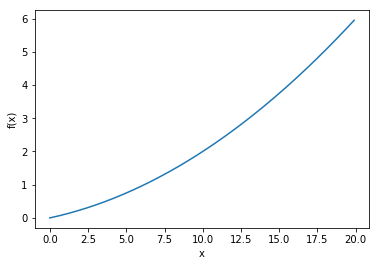

In [0]:
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [0]:
# x=5, x=10で微分する
print(numerical_diff(func_1, 5))
print(numerical_diff(func_1, 10))

0.1999999999990898
0.2999999999986347


### 偏微分の例
偏微分=変数が複数ある場合の微分。

$f(x_{0}, x_{1})=x^2_{0}+x^2_{1}$

各変数に対する偏微分は以下のように表される。

$\frac{\partial f}{\partial x_{0}}$, $\frac{\partial f}{\partial x_{1}}$

In [0]:
def func_2(x):
  return x[0]**2 + x[1]**2

In [0]:
# x0 = 3, x1 = 4のときのx0に対する偏微分
def func_tmp1(x0):
  return x0*x0 + 4.0**2.0

numerical_diff(func_tmp1, 3.0)

6.00000000000378

In [0]:
# x0 = 3, x1 = 4のときのx1に対する偏微分
def func_tmp2(x1):
  return 3.0**2.0 + x1*x1

numerical_diff(func_tmp2, 4.0)

7.999999999999119

## 勾配
複数の変数があるとき、すべての変数の偏微分をベクトルとしてまとめたものを**勾配(gradient)**と言い以下のように表記する。

$(\frac{\partial f}{\partial x_{0}}, \frac{\partial f}{\partial x_{1}})$

勾配は各場所（入力）において、**関数の値を最も減らす方向**を示す。

In [0]:
def numerical_gradient(f, x):
  h = 1e-4 # 0.0001
  grad = np.zeros_like(x) # xと同じ形状の配列を生成
  
  for idx in range(x.size):
    tmp_val = x[idx]
    # f(x+h)の計算
    x[idx] = tmp_val + h
    fxh1 = f(x)
    
    # f(x-h)の計算
    x[idx] = tmp_val - h
    fxh2 = f(x)
    
    grad[idx] = (fxh1 - fxh2) / (2*h)
    x[idx] = tmp_val # 値をもとに戻す
    
  return grad

In [0]:
numerical_gradient(func_2, np.array([3.0, 4.0]))

array([6., 8.])

In [0]:
numerical_gradient(func_2, np.array([0.0, 2.0]))

array([0., 4.])

In [0]:
numerical_gradient(func_2, np.array([3.0, 0.0]))

array([6., 0.])

### 勾配法
関数を最小化する（最小とは限らないが減少させる）ためには、現在の場所から勾配方向に一定距離進み、移動した地点から再度勾配を計算することを一定回数繰り返すことで最小値（あるいは極小値）を求める。これが**勾配法**である。

2変数の勾配法は以下のように表される。

$x_{0}=x_{0}-\eta\frac{\partial f}{\partial x_{0}}$

$x_{1}=x{1}-\eta\frac{\partial f}{\partial x_{1}}$


$\eta$は**学習率(learning rate)**と呼ばれ、1回の学習でどれだけパラメータを更新すべきかを決める（=勾配方向への移動量を決める）。

学習率は大きすぎても小さすぎても「良い場所」に収束しないので、0.01や0.001などの値を試行錯誤する必要がある。ニューラルネットワークで学習させる重み（パラメータ）とは異なり、学習のために任意に決める必要がある値を**ハイパーパラメータ**と言う。

In [0]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
  x = init_x
  
  for i in range(step_num):
    grad = numerical_gradient(f, x)
    x -= lr * grad
  
  return x

In [0]:
init_x = np.array([-3.0, 4.0])
gradient_descent(func_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

In [0]:
# 学習率が大きすぎる場合
gradient_descent(func_2, init_x=init_x, lr=10.0, step_num=100)

array([ 2.34235971e+12, -3.96091057e+12])

In [0]:
# 学習率が小さすぎる場合
gradient_descent(func_2, init_x=init_x, lr=1e-20, step_num=100)

array([ 2.34235971e+12, -3.96091057e+12])

### ニューラルネットワークに対する勾配
$2 \times 3$の重み$W$だけを持つニューラルネットワークがあり、損失関数を$L$で表した場合、勾配は$\frac{\partial L}{\partial W}$となり、以下の数式で表すことができる。

\\

$W=
\begin{pmatrix}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23} \\
\end{pmatrix}
$

\\

$\frac{\partial L}{\partial W}=
\begin{pmatrix}
\frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{12}} & \frac{\partial L}{\partial w_{13}} \\
\frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{22}} & \frac{\partial L}{\partial w_{23}}
\end{pmatrix}
$

In [0]:
def softmax(a):
  c = np.max(a)
  exp_a = np.exp(a - c) # オーバーフロー対策
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  
  return y

In [0]:
class simpleNet:
  def __init__(self):
    self.W = np.random.randn(2, 3) # ガウス分布で初期化
    
  def predict(self, x):
    return np.dot(x, self.W)
  
  def loss(self, x, t):
    z = self.predict(x)
    y = softmax(z)
    loss = cross_entropy_error2(y, t)
    
    return loss

In [0]:
net = simpleNet()
print(net.W)

[[-0.13922211  0.6842476  -0.62269829]
 [-0.52392177  0.46659375  0.06449104]]


In [0]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.55506286  0.83048293 -0.31557704]


In [0]:
np.argmax(p)

1

In [0]:
t = np.array([0, 0, 1])
net.loss(x, t)

1.5959075919805443

In [0]:
def f(W):
  return net.loss(x, t)

In [0]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [0]:
dw = numerical_gradient(f, net.W)
print(dw)

[[ 0.09573034  0.38263481 -0.47836515]
 [ 0.14359551  0.57395222 -0.71754773]]


In [0]:
# lambda版
f = lambda w: net.loss(x, t)
dw = numerical_gradient(f, net.W)
print(dw)

[[ 0.09573034  0.38263481 -0.47836515]
 [ 0.14359551  0.57395222 -0.71754773]]


## 学習アルゴリズムの実装
ニューラルネットワークとは、適応可能な（=可変の）重みとバイアスを持つネットワーク構造であり、その重みとバイアスを訓練データに適応するように調整することを「学習」と呼ぶ。

ニューラルネットワークの学習アルゴリズムは以下の手順で実装できる。

* ミニバッチ
  * 訓練データからランダムに一部のデータ（=ミニバッチ）を選び出す
  * 選びだしたミニバッチの損失関数の値を減少させるようにする
* 勾配の計算
  * ミニバッチの損失関数を減らすために各重みパラメータの勾配を求める（=パラメータごとに偏微分する）
  * 勾配は損失関数を最も減少させる方向を示す
* パラメータの更新
  * 重みパラメータを勾配方向に微小量（学習率）だけ更新する。
* 繰り返す
  * 上記手順を値が収束するか一定の条件（回数or損失関数の減少量が一定以下になる）まで繰り返す
  
上記手順はミニバッチを無作為（=ランダム）に選んで学習を行うことから**確率的勾配降下法(Stochastic Gradient Descent=SGD)**と呼ばれる。

以下では隠れ層が1層の2層ニューラルネットワークを実装する。

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [0]:
class TwoLayerNet:
  
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)
    
  def predict(self, x):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)
    
    return y
  
  # x: 入力データ, t: 教師データ
  def loss(self, x, t):
    y = self.predict(x)
    
    return cross_entropy_error2(y, t)
  
  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)
    
    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy
  
  # x: 入力データ, t: 教師データ
  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)
    
    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    
    return grads

In [0]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [0]:
x = np.random.rand(100, 784)
y = net.predict(x)
# print(y)

In [0]:
# 完了まで数分かかるので注意されたし
t = np.random.rand(100, 10)
grads = net.numerical_gradient(x, t)

print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [0]:
# さらに時間がかかる…

train_loss_list = []

# ハイパーパラメータ
iters_num = 10000
train_size = x_train_normalized.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train_normalized[batch_mask]
  t_batch = y_train_onehot[batch_mask]
  
  grad = network.numerical_gradient(x_batch, t_batch)
  
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]
    
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
